In [ ]:
'''
The code aims to construct tobacco mof automatically. This scripts shows a successful example: Zr12 structure
The script is tested in Zr12 structure and environment yfh
'''

In [17]:
'''
The first part is to use K-means++ methods to identify metal clusters:
Three key points:
1. The distance function should consider periodic conditions: ase.geometry.get_distances()
2. The centers assignment should consider periodic conditions: I define it by myself, based on wrap_positions in ase
3. The elbow point should be found automatically and I should visualize coordinates with different k values in order to check it

So let's go
'''

from ase.io import read, write
#from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import type_metric, distance_metric
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from matplotlib import pyplot as plt
from ase.geometry import get_distances
from pyclustering.cluster.silhouette import silhouette
from ase.geometry import wrap_positions
from kneed import DataGenerator, KneeLocator

import copy
import numpy

import matplotlib.pyplot as plt
import matplotlib.animation as animation

import pyclustering.core.kmeans_wrapper as wrapper

#from pyclustering.core.wrapper import ccore_library
from pyclustering.core.metric_wrapper import metric_wrapper

from pyclustering.cluster.encoder import type_encoding
from pyclustering.cluster import cluster_visualizer

from pyclustering.utils.metric import distance_metric, type_metric

def center_assig(pos_arr, cell, reci_cell, pbc):
    neigh = np.dot(pos_arr[0], reci_cell.T)
    pos_new = wrap_positions(pos_arr, cell=cell, pbc=pbc, center=neigh)
    new_center = np.sum(pos_new, axis=0)/pos_new.shape[0]
    return new_center

# I do not use this function finally because it break the elbow curve
def cut_fuc(distance):
    if distance < 5: return 0
    else: return distance

class kmeans_new:
    """!
    @brief Class implements K-Means clustering algorithm.
    @details K-Means clustering aims to partition n observations into k clusters in which each observation belongs to
              the cluster with the nearest mean, serving as a prototype of the cluster. This results in a partitioning
              of the data space into Voronoi cells.

    K-Means clustering results depend on initial centers. Algorithm K-Means++ can used for initialization of
    initial centers - see module 'pyclustering.cluster.center_initializer'.

    CCORE implementation (C/C++ part of the library) of the algorithm performs parallel processing to ensure maximum
    performance.

    Implementation based on the paper @cite inproceedings::kmeans::1.

    @image html kmeans_example_clustering.png "Fig. 1. K-Means clustering results. At the left - 'Simple03.data' sample, at the right - 'Lsun.data' sample."

    Example #1 - Clustering using K-Means++ for center initialization:
    @code
        from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
        from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
        from pyclustering.samples.definitions import FCPS_SAMPLES
        from pyclustering.utils import read_sample

        # Load list of points for cluster analysis.
        sample = read_sample(FCPS_SAMPLES.SAMPLE_TWO_DIAMONDS)

        # Prepare initial centers using K-Means++ method.
        initial_centers = kmeans_plusplus_initializer(sample, 2).initialize()

        # Create instance of K-Means algorithm with prepared centers.
        kmeans_instance = kmeans(sample, initial_centers)

        # Run cluster analysis and obtain results.
        kmeans_instance.process()
        clusters = kmeans_instance.get_clusters()
        final_centers = kmeans_instance.get_centers()

        # Visualize obtained results
        kmeans_visualizer.show_clusters(sample, clusters, final_centers)
    @endcode

    Example #2 - Clustering using specific distance metric, for example, Manhattan distance:
    @code
        # prepare input data and initial centers for cluster analysis using K-Means

        # create metric that will be used for clustering
        manhattan_metric = distance_metric(type_metric.MANHATTAN)

        # create instance of K-Means using specific distance metric:
        kmeans_instance = kmeans(sample, initial_centers, metric=manhattan_metric)

        # run cluster analysis and obtain results
        kmeans_instance.process()
        clusters = kmeans_instance.get_clusters()
    @endcode

    Implementation based on paper @cite inproceedings::kmeans::1.

    @see center_initializer
    
    """
    
    def __init__(self, data, initial_centers, atoms, tolerance=0.001, ccore=True, **kwargs):
        """!
        @brief Constructor of clustering algorithm K-Means.
        @details Center initializer can be used for creating initial centers, for example, K-Means++ method.
        
        @param[in] data (array_like): Input data that is presented as array of points (objects), each point should be represented by array_like data structure.
        @param[in] initial_centers (array_like): Initial coordinates of centers of clusters that are represented by array_like data structure: [center1, center2, ...].
        @param[in] tolerance (double): Stop condition: if maximum value of change of centers of clusters is less than tolerance then algorithm stops processing.
        @param[in] ccore (bool): Defines should be CCORE library (C++ pyclustering library) used instead of Python code or not.
        @param[in] **kwargs: Arbitrary keyword arguments (available arguments: 'observer', 'metric', 'itermax').
        
        <b>Keyword Args:</b><br>
            - observer (kmeans_observer): Observer of the algorithm to collect information about clustering process on each iteration.
            - metric (distance_metric): Metric that is used for distance calculation between two points (by default euclidean square distance).
            - itermax (uint): Maximum number of iterations that is used for clustering process (by default: 200).
        
        @see center_initializer
        
        """
        self.__pointer_data = numpy.array(data)
        self.__clusters = []
        self.__centers = numpy.array(initial_centers)
        self.__tolerance = tolerance
        self.__total_wce = 0.0
        self.atoms = atoms

        self.__observer = kwargs.get('observer', None)
        self.__metric = copy.copy(kwargs.get('metric', distance_metric(type_metric.EUCLIDEAN_SQUARE)))
        self.__itermax = kwargs.get('itermax', 100)

        if self.__metric.get_type() != type_metric.USER_DEFINED:
            self.__metric.enable_numpy_usage()
        else:
            self.__metric.disable_numpy_usage()

        self.__ccore = ccore and self.__metric.get_type() != type_metric.USER_DEFINED
        if self.__ccore is True:
            self.__ccore = ccore_library.workable()

        self.__verify_arguments()


    def process(self):
        """!
        @brief Performs cluster analysis in line with rules of K-Means algorithm.

        @return (kmeans) Returns itself (K-Means instance).
        
        @see get_clusters()
        @see get_centers()
        
        """

        if len(self.__pointer_data[0]) != len(self.__centers[0]):
            raise ValueError("Dimension of the input data and dimension of the initial cluster centers must be equal.")

        if self.__ccore is True:
            self.__process_by_ccore()
        else:
            self.__process_by_python()

        return self


    def __process_by_ccore(self):
        """!
        @brief Performs cluster analysis using CCORE (C/C++ part of pyclustering library).

        """
        ccore_metric = metric_wrapper.create_instance(self.__metric)

        results = wrapper.kmeans(self.__pointer_data, self.__centers, self.__tolerance, self.__itermax,
                                 (self.__observer is not None), ccore_metric.get_pointer())

        self.__clusters = results[0]
        self.__centers = results[1]

        if self.__observer is not None:
            self.__observer.set_evolution_clusters(results[2])
            self.__observer.set_evolution_centers(results[3])

        self.__total_wce = results[4][0]


    def __process_by_python(self):
        """!
        @brief Performs cluster analysis using python code.

        """

        maximum_change = float('inf')
        iteration = 0

        if self.__observer is not None:
            initial_clusters = self.__update_clusters()
            self.__observer.notify(initial_clusters, self.__centers.tolist())

        while maximum_change > self.__tolerance and iteration < self.__itermax:
            self.__clusters = self.__update_clusters()
            updated_centers = self.__update_centers()  # changes should be calculated before assignment

            if self.__observer is not None:
                self.__observer.notify(self.__clusters, updated_centers.tolist())

            maximum_change = self.__calculate_changes(updated_centers)

            self.__centers = updated_centers    # assign center after change calculation
            iteration += 1

        self.__calculate_total_wce()


    def predict(self, points):
        """!
        @brief Calculates the closest cluster to each point.

        @param[in] points (array_like): Points for which closest clusters are calculated.

        @return (list) List of closest clusters for each point. Each cluster is denoted by index. Return empty
                 collection if 'process()' method was not called.

        """

        nppoints = numpy.array(points)
        if len(self.__clusters) == 0:
            return []

        differences = numpy.zeros((len(nppoints), len(self.__centers)))
        for index_point in range(len(nppoints)):
            if self.__metric.get_type() != type_metric.USER_DEFINED:
                differences[index_point] = self.__metric(nppoints[index_point], self.__centers)
            else:
                differences[index_point] = [self.__metric(nppoints[index_point], center) for center in self.__centers]

        return numpy.argmin(differences, axis=1)


    def get_clusters(self):
        """!
        @brief Returns list of allocated clusters, each cluster contains indexes of objects in list of data.
        
        @see process()
        @see get_centers()
        
        """
        
        return self.__clusters


    def get_centers(self):
        """!
        @brief Returns list of centers of allocated clusters.
        
        @see process()
        @see get_clusters()
        
        """

        if isinstance(self.__centers, list):
            return self.__centers

        return self.__centers.tolist()


    def get_total_wce(self):
        """!
        @brief Returns sum of metric errors that depends on metric that was used for clustering (by default SSE - Sum of Squared Errors).
        @details Sum of metric errors is calculated using distance between point and its center:
                 \f[error=\sum_{i=0}^{N}distance(x_{i}-center(x_{i}))\f]

        @see process()
        @see get_clusters()

        """

        return self.__total_wce


    def get_cluster_encoding(self):
        """!
        @brief Returns clustering result representation type that indicate how clusters are encoded.
        
        @return (type_encoding) Clustering result representation.
        
        @see get_clusters()
        
        """
        
        return type_encoding.CLUSTER_INDEX_LIST_SEPARATION


    def __update_clusters(self):
        """!
        @brief Calculate distance (in line with specified metric) to each point from the each cluster. Nearest points
                are captured by according clusters and as a result clusters are updated.
        
        @return (list) Updated clusters as list of clusters. Each cluster contains indexes of objects from data.
        
        """
        
        clusters = [[] for _ in range(len(self.__centers))]
        
        dataset_differences = self.__calculate_dataset_difference(len(clusters))
        
        optimum_indexes = numpy.argmin(dataset_differences, axis=0)
        for index_point in range(len(optimum_indexes)):
            index_cluster = optimum_indexes[index_point]
            clusters[index_cluster].append(index_point)
        
        clusters = [cluster for cluster in clusters if len(cluster) > 0]

        return clusters


    def __update_centers(self):
        """!
        @brief Calculate centers of clusters in line with contained objects.
        
        @return (numpy.array) Updated centers.
        
        """
        
        dimension = self.__pointer_data.shape[1]
        centers = numpy.zeros((len(self.__clusters), dimension))
        
        for index in range(len(self.__clusters)):
            cluster_points = self.__pointer_data[self.__clusters[index], :]
            centers[index] = center_assig(cluster_points, self.atoms.get_cell(),self.atoms.get_reciprocal_cell(), self.atoms.pbc)
            #centers[index] = cluster_points.mean(axis=0)

        return numpy.array(centers)


    def __calculate_total_wce(self):
        """!
        @brief Calculate total within cluster errors that is depend on metric that was chosen for K-Means algorithm.

        """

        dataset_differences = self.__calculate_dataset_difference(len(self.__clusters))

        self.__total_wce = 0.0
        for index_cluster in range(len(self.__clusters)):
            for index_point in self.__clusters[index_cluster]:
                self.__total_wce += dataset_differences[index_cluster][index_point]


    def __calculate_dataset_difference(self, amount_clusters):
        """!
        @brief Calculate distance from each point to each cluster center.

        """
        dataset_differences = numpy.zeros((amount_clusters, len(self.__pointer_data)))
        for index_center in range(amount_clusters):
            if self.__metric.get_type() != type_metric.USER_DEFINED:
                dataset_differences[index_center] = self.__metric(self.__pointer_data, self.__centers[index_center])
            else:
                dataset_differences[index_center] = [self.__metric(point, self.__centers[index_center])
                                                     for point in self.__pointer_data]

        return dataset_differences


    def __calculate_changes(self, updated_centers):
        """!
        @brief Calculates changes estimation between previous and current iteration using centers for that purpose.

        @param[in] updated_centers (array_like): New cluster centers.

        @return (float) Maximum changes between centers.

        """
        if len(self.__centers) != len(updated_centers):
            maximum_change = float('inf')

        else:
            if self.__metric.get_type() != type_metric.USER_DEFINED:
                changes = self.__metric(self.__centers, updated_centers)
            else:
                changes = [self.__metric(center, updated_center) for center, updated_center in zip(self.__centers, updated_centers)]

            maximum_change = numpy.max(changes)

        return maximum_change


    def __verify_arguments(self):
        """!
        @brief Verify input parameters for the algorithm and throw exception in case of incorrectness.

        """
        if len(self.__pointer_data) == 0:
            raise ValueError("Input data is empty (size: '%d')." % len(self.__pointer_data))

        if len(self.__centers) == 0:
            raise ValueError("Initial centers are empty (size: '%d')." % len(self.__pointer_data))

        if self.__tolerance < 0:
            raise ValueError("Tolerance (current value: '%d') should be greater or equal to 0." %
                             self.__tolerance)

        if self.__itermax < 0:
            raise ValueError("Maximum iterations (current value: '%d') should be greater or equal to 0." %
                             self.__tolerance)


this is the initial legenth: 1


/home/jyb/.local/lib/python3.8/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.reciprocal()
  warnings.warn(warning)


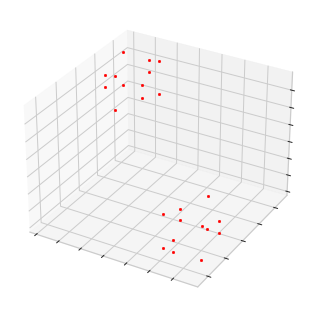

one times
1 1
this is the initial legenth: 2


/home/jyb/.local/lib/python3.8/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.reciprocal()
  warnings.warn(warning)


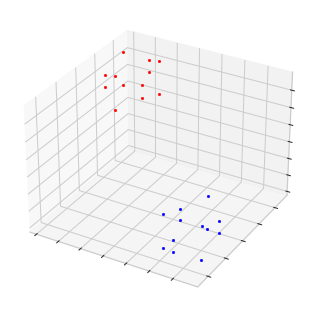

one times
2 2
this is the initial legenth: 3


/home/jyb/.local/lib/python3.8/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.reciprocal()
  warnings.warn(warning)


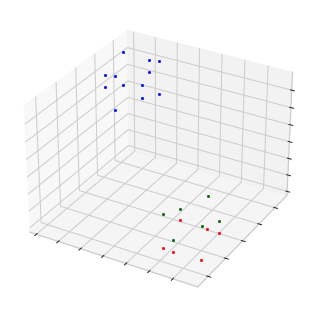

one times
3 3
this is the initial legenth: 4


/home/jyb/.local/lib/python3.8/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.reciprocal()
  warnings.warn(warning)


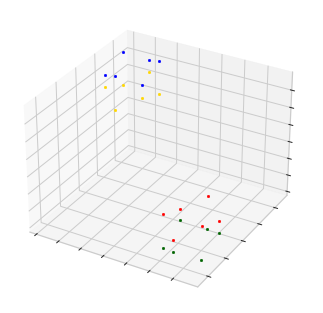

one times
4 4
this is the initial legenth: 5


/home/jyb/.local/lib/python3.8/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.reciprocal()
  warnings.warn(warning)


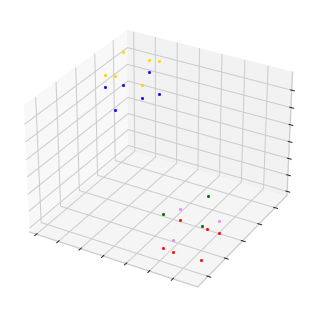

one times
5 5
this is the initial legenth: 6


/home/jyb/.local/lib/python3.8/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.reciprocal()
  warnings.warn(warning)


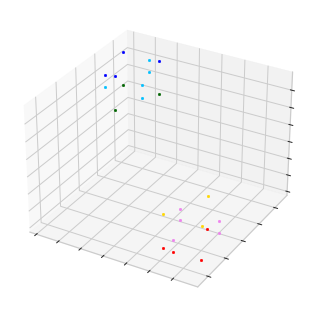

one times
6 6
this is the initial legenth: 7


/home/jyb/.local/lib/python3.8/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.reciprocal()
  warnings.warn(warning)


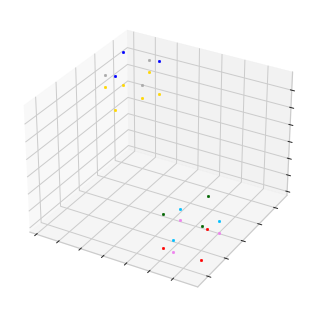

one times
7 7
this is the initial legenth: 8


/home/jyb/.local/lib/python3.8/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.reciprocal()
  warnings.warn(warning)


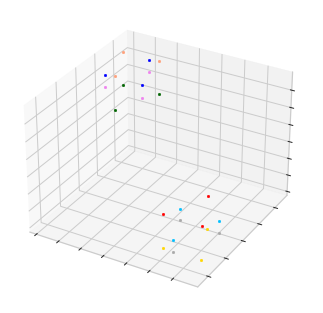

one times
8 8
this is the initial legenth: 9


/home/jyb/.local/lib/python3.8/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.reciprocal()
  warnings.warn(warning)


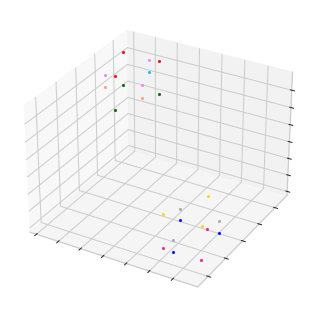

one times
9 9


In [18]:
atoms = read("/home/jyb/lyt/dataset/exp_cifs/zr12-bpdc-mini-metal.cif")
pos_arr = atoms.get_positions()

k_min = 1
k_max = 10

'''
collect all errors and 
'''


user_function = lambda point1, point2: get_distances(point1, point2, cell=atoms.cell, pbc=atoms.pbc)[-1][0][0]
metric = distance_metric(type_metric.USER_DEFINED, func=user_function)
'''

def cut_fuc(distance):
    if distance < 6: return 0
    else: return distance


user_function = lambda point1, point2: cut_fuc(get_distances(point1, point2, cell=atoms.cell, pbc=atoms.pbc)[-1][0][0])
metric = distance_metric(type_metric.USER_DEFINED, func=user_function)
'''
score_ls = []

for i in range(k_min, k_max):
    n_cluster = i
    # create K-Means algorithm with specific distance metric
    initial_centers = kmeans_plusplus_initializer(pos_arr, n_cluster, metric=metric).initialize()
    print("this is the initial legenth:",len(initial_centers))
    kmeans_instance = kmeans_new(pos_arr, initial_centers, atoms, ccore=False, metric=metric)
    #kmeans_instance = kmeans(pos_arr, initial_centers, ccore=False, metric=metric)
    #kmeans_instance = kmeans(pos_arr, initial_centers)
    # run cluster analysis and obtain results
    kmeans_instance.process()
    clusters = kmeans_instance.get_clusters()   
    score_ls.append(kmeans_instance.get_total_wce())
    visualizer = cluster_visualizer()
    visualizer.append_clusters(clusters, pos_arr)
    visualizer.show()
    print("one times")
    print(len(clusters),i)
#visualizer.show()

In [30]:
kneedle = KneeLocator(range(k_min, k_max), score_ls, S=1.0, curve="convex", direction="decreasing")
print(kneedle.elbow)

2


2


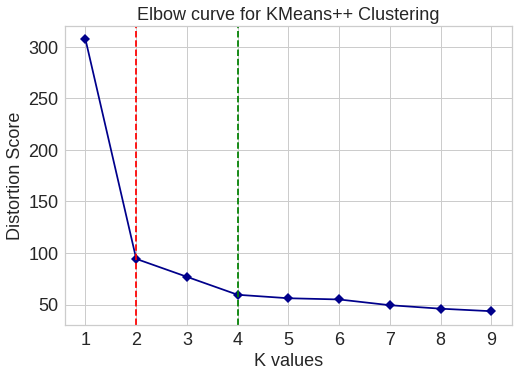

In [52]:
fz = 18

plt.title("Elbow curve for KMeans++ Clustering",fontsize=fz)
plt.xlabel("K values", fontsize=fz)
plt.ylabel("Distortion Score", fontsize=fz)
plt.xticks(fontsize=fz)
plt.yticks(fontsize=fz)
plt.plot(range(k_min, k_max),score_ls,marker='D',c='darkblue')
kneedle = KneeLocator(range(k_min, k_max), score_ls, S=1.0, curve="convex", direction="decreasing")
print(kneedle.elbow)
# 画出 x=2 这条垂直线
plt.axvline(kneedle.elbow,linestyle='dashed',c="red")
plt.axvline(4,linestyle='dashed',c="green")

this is the initial legenth: 4


/home/jyb/.local/lib/python3.8/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.reciprocal()
  warnings.warn(warning)


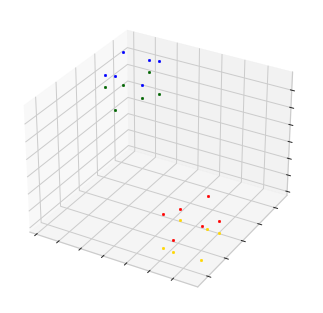

one times
4 4


In [71]:
'''

The second part: from the elbow curve and visualization of 3D coordinates, we can get correct k value by hand 

For Zr 12 example k=4

'''
n_cluster = 4
# create K-Means algorithm with specific distance metric
initial_centers = kmeans_plusplus_initializer(pos_arr, n_cluster, metric=metric).initialize()
print("this is the initial legenth:",len(initial_centers))
kmeans_instance = kmeans_new(pos_arr, initial_centers, atoms, ccore=False, metric=metric)
#kmeans_instance = kmeans(pos_arr, initial_centers, ccore=False, metric=metric)
#kmeans_instance = kmeans(pos_arr, initial_centers)
# run cluster analysis and obtain results
kmeans_instance.process()
clusters = kmeans_instance.get_clusters()   
score_ls.append(kmeans_instance.get_total_wce())
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, pos_arr)
visualizer.show()
print("one times")
print(len(clusters),n_cluster)
centers = kmeans_instance.get_centers()

In [78]:
'''
The third part is to generate the template file according to the clustering result
'''
from ase.calculators.neighborlist import NeighborList
from ase import Atoms
import numpy as np

def PBC3DF_sym(dX,dY,dZ):
	if dX > 0.5:
		s1 = 1 + 5 
		ndX = dX - 1.0
	elif dX < -0.5:
		s1 = -1 + 5
		ndX = dX + 1.0
	else:
		s1 = 0 + 5
		ndX = dX
				
	if dY > 0.5:
		s2 = 1 + 5
		ndY = dY - 1.0
	elif dY < -0.5:
		s2 = -1 + 5
		ndY = dY + 1.0
	else:
		s2 = 0 + 5
		ndY = dY
	
	if dZ > 0.5:
		s3 = 1 + 5
		ndZ = dZ - 1.0
	elif dZ < -0.5:
		s3 = -1 + 5
		ndZ = dZ + 1.0
	else:
		s3 = 0 + 5
		ndZ = dZ

	if str(s1) + str(s2) + str(s3) == '555':
		sym = '.'
	else:
		sym = '1_' + str(s1) + str(s2) + str(s3)

	return sym



def setdiff2d_set(arr1, arr2):
    set1 = set(map(tuple, np.array(arr1)))
    set2 = set(map(tuple, np.array(arr2)))
    return np.array(list(set1 - set2))

def check_connectivity(centers, cell, pbc, length, del_num):
    '''
    After getting centers from K-means++, compute the connectivity of centers and
    return a fixed-bonds list
    '''
    
    '''
    For distance minimum
    '''
    num = centers.shape[0]
    
    cutoff_ls = [length*0.5*0.8]*num
    nl = NeighborList(cutoff_ls, skin=0, self_interaction=False, bothways=True)
    nl.update(Atoms(positions=centers,cell=cell,pbc=pbc))
    short_arr = np.concatenate((np.matrix(nl.get_neighbors(0)[0]).T, nl.get_neighbors(0)[1]), axis=1)
    
    '''
    For distance maximum
    '''
    
    num = centers.shape[0]
    
    cutoff_ls = [length*0.5*1.1]*num
    nl = NeighborList(cutoff_ls, skin=0, self_interaction=False, bothways=True)
    nl.update(Atoms(positions=centers,cell=cell,pbc=pbc))
    long_arr = np.concatenate((np.matrix(nl.get_neighbors(0)[0]).T, nl.get_neighbors(0)[1]), axis=1)
    
    fixed_bonds = []
    fixed_bonds_append = fixed_bonds.append
    coor_arr = setdiff2d_set(long_arr,short_arr)
    number = 0
    refer_arr = centers[number]
    #print("this is refer_arr", refer_arr)
    pbc_diff = coor_arr[:,1:]@ atoms.get_cell() # minus symbol very important, + cause errors 
    for i in range(0,coor_arr.shape[0]):
        new_pos = centers[coor_arr[i,0]]+pbc_diff[i]
        diff_vec = np.array(new_pos-refer_arr)[0]
        dr = np.dot(diff_vec, atoms.get_reciprocal_cell().T)
        dist = np.linalg.norm(diff_vec)
        '''
        if dist>20:
            print(coor_arr[i,1:])
            print(centers[coor_arr[i,0]],pbc_diff[i],new_pos)
            print("this is minum distances:",get_distances(np.array(centers[coor_arr[i,0]]), np.array(refer_arr),cell=cell,pbc=pbc))
            print("this is minum distances II:",get_distances(np.array(new_pos), np.array(refer_arr),cell=cell,pbc=pbc))
        '''
        sym = PBC3DF_sym(dr[0],dr[1],dr[2])
        bond_ls = [number+del_num, coor_arr[i,0]+del_num, dist, sym, 'S']
        #print(bond_ls)
        fixed_bonds_append(bond_ls)
    
    return fixed_bonds

fixed_bonds_all = []

# centers has already been defined above: centers = kmeans_instance.get_centers()
centers = np.matrix(kmeans_instance.get_centers())
k=0
while centers.size>0:
    fixed_bonds_all.extend(check_connectivity(centers, cell=atoms.cell, pbc=atoms.pbc, length=18, del_num=k))
    k+=1
    centers = centers[k:]
#print(len(fixed_bonds_all))
for fixed_bond in fixed_bonds_all:
    print(fixed_bond)

[0, 0, 18.95, '1_565', 'S']
[0, 0, 18.95, '1_455', 'S']
[0, 0, 18.95, '1_545', 'S']
[0, 0, 18.95, '1_655', 'S']
[0, 0, 18.950000000000003, '1_665', 'S']
[0, 2, 18.845358853062912, '.', 'S']
[0, 0, 18.95, '1_445', 'S']
[0, 2, 18.845358853062915, '1_655', 'S']
[0, 2, 18.845358853062915, '1_545', 'S']
[1, 1, 18.95, '1_565', 'S']
[1, 3, 18.845358853062915, '.', 'S']
[1, 1, 18.95, '1_545', 'S']
[1, 1, 18.95, '1_655', 'S']
[1, 1, 18.95, '1_455', 'S']
[1, 1, 18.95, '1_665', 'S']
[1, 3, 18.845358853062915, '1_455', 'S']
[1, 1, 18.95, '1_445', 'S']
[1, 3, 18.845358853062915, '1_565', 'S']
[2, 2, 18.95, '1_445', 'S']
[2, 2, 18.95, '1_565', 'S']
[2, 2, 18.95, '1_455', 'S']
[2, 2, 18.949999999999996, '1_545', 'S']
[2, 2, 18.95, '1_655', 'S']
[2, 2, 18.95, '1_665', 'S']


/home/jyb/.local/lib/python3.8/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.reciprocal()
  warnings.warn(warning)


In [85]:
'''
The third part is to output the template file as a cif 
'''
import os
def write_cif(frac_pos, fixed_bonds, scaled_params, cifname):
    '''
    Based on tobacco, I use V as chemical symbols. if necessary, you can change it freely
    '''
    symbol = 'V'
    sc_a,sc_b,sc_c,sc_alpha,sc_beta,sc_gamma = scaled_params
    opath = os.path.join('/home/jyb/lyt/output_cifs', cifname) # this is the output files path
    
    with open(opath, 'w') as out:
        out.write('data_' + cifname[0:-4] + '\n')
        out.write("_audit_creation_method            'tobacco_3.0'" + '\n')
        out.write("_symmetry_space_group_name_H-M    'P1'" + '\n')
        out.write('_symmetry_Int_Tables_number       1' + '\n')
        out.write('_symmetry_cell_setting            triclinic' + '\n')
        out.write('loop_' + '\n')
        out.write('_symmetry_equiv_pos_as_xyz' + '\n')
        out.write('  x,y,z' + '\n')
        out.write('_cell_length_a                    ' + str(sc_a) + '\n')
        out.write('_cell_length_b                    ' + str(sc_b) + '\n')
        out.write('_cell_length_c                    ' + str(sc_c) + '\n')
        out.write('_cell_angle_alpha                 ' + str(sc_alpha) + '\n')
        out.write('_cell_angle_beta                  ' + str(sc_beta) + '\n')
        out.write('_cell_angle_gamma                 ' + str(sc_gamma) + '\n')
        out.write('loop_' + '\n')
        out.write('_atom_site_label' + '\n')
        out.write('_atom_site_type_symbol' + '\n')
        out.write('_atom_site_fract_x' + '\n')
        out.write('_atom_site_fract_y' + '\n')
        out.write('_atom_site_fract_z' + '\n')
        
        for idx in range(0,frac_pos.shape[0]):
            cvec = frac_pos[idx][0][0]#list(map(float, l[1:4]))
            cvec = np.mod(cvec, 1) # makes sure that all fractional coordinates are in [0,1]
            out.write('{:7} {:>4} {:>15} {:>15} {:>15}'.format(symbol+str(idx+1), symbol, "%.10f" % np.round(cvec[0,0],10), "%.10f" % np.round(cvec[0,1],10), "%.10f" % np.round(cvec[0,2],10)))
            out.write('\n')
        out.write('loop_' + '\n')
        out.write('_geom_bond_atom_site_label_1' + '\n')
        out.write('_geom_bond_atom_site_label_2' + '\n')
        out.write('_geom_bond_distance' + '\n')
        out.write('_geom_bond_site_symmetry_2' + '\n')
        out.write('_ccdc_geom_bond_type' + '\n')

        for e in fixed_bonds:
            out.write('{:7} {:>7} {:>5} {:>7} {:>3}'.format(symbol+str(e[0]+1), symbol+str(e[1]+1), "%.3f" % float(e[2]), e[3], e[4]))
            out.write('\n')
frac_pos = np.dot(np.matrix(kmeans_instance.get_centers()), atoms.get_reciprocal_cell().T)
scaled_params = atoms.get_cell_lengths_and_angles()
write_cif(frac_pos, fixed_bonds_all, scaled_params, 'zr12.cif')

/home/jyb/.local/lib/python3.8/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.reciprocal()
  warnings.warn(warning)
/home/jyb/.local/lib/python3.8/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)
